# Management Sentiment Analysis 

_Life is a math equation. In order to gain the most, you have to know how to convert negatives into positives_ - Anonymous


Sentiment analysis helps quantify the tone of financial disclosures, revealing whether a company’s management expresses optimism, caution, or concern. This analysis can be conducted using dictionary-based methods, which rely on predefined sentiment word lists, or more sophisticated machine learning models, such as large language models (LLMs). We explore the application of sentiment analysis in financial documents, focusing on the Loughran-MacDonald dictionary and the SEC’s EDGAR system for retrieving company filings.  Specifically, we analyze sentiment trends in 10-K Management Discussion and Analysis (MD&A) sections and their relationship with stock returns.




In [1]:
# By: Terence Lim, 2020-2025 (terence-lim.github.io)
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
from finds.database import SQL, RedisDB
from finds.structured import BusDay, CRSP, Signals
from finds.unstructured import Edgar
from finds.readers import Alfred
from finds.recipes import weighted_average, fractile_split
from finds.utils import Store
from secret import credentials, paths, CRSP_DATE
# %matplotlib qt
VERBOSE = 0
LAST_YEAR = CRSP_DATE // 10000

In [2]:
sql = SQL(**credentials['sql'], verbose=VERBOSE)
user = SQL(**credentials['user'], verbose=VERBOSE)
bd = BusDay(sql)
rdb = RedisDB(**credentials['redis'])
crsp = CRSP(sql=sql, bd=bd, rdb=rdb, verbose=VERBOSE)
signals = Signals(user)
store = Store(paths['scratch'], ext='pkl')

## Sentiment analysis

Dictionary-based (or lexicon-based) sentiment analysis relies on predefined word lists, where words are assigned sentiment scores along with intensity levels. While this approach is straightforward and computationally efficient, it struggles with complex linguistic phenomena such as negations, irony, and sarcasm, which can lead to reduced accuracy. On the other hand, large language models excel at understanding context, syntax, and semantics, making them more effective for sentiment analysis of intricate financial texts. However, despite their limitations, dictionary-based methods remain popular due to their ease of implementation and transparent results.

### Loughran-MacDonald dictionary

Loughran and McDonald (2011) found that general-purpose sentiment lexicons were not well-suited for financial statement analysis. To address this, they developed a dictionary based on company 10-K filings, categorizing words into seven sentiment-related groups relevant to finance: "negative," "positive," "litigious," "uncertainty," "constraining," and "superfluous." This domain-specific approach provides a more accurate reflection of sentiment in financial disclosures.

- [Loughran-MacDonald Master Dictionary](https://sraf.nd.edu/loughranmcdonald-master-dictionary/)

The dictionary includes:
- A list of positive sentiment words
- A list of negative sentiment words
- A set of stop words to ignore




In [3]:
# to download from google drive, need this prefix and the source file id
_prefix = "https://drive.google.com/uc?export=download&id=" 
source =  _prefix + '1ptUgGVeeUGhCbaKL14Ri3Xi5xOKkPkUD'
# source = "Loughran-McDonald_MasterDictionary_1993-2023.csv"
df = pd.read_csv(source, sep=',')

# sets of positive and negative sentiment words
words = {'positive': set(df.loc[df['Positive'] != 0, 'Word'].str.lower()),
         'negative': set(df.loc[df['Negative'] != 0, 'Word'].str.lower())}

Positive sentiment words

In [4]:
DataFrame(words['positive'], columns=['Positive Words'])

,Positive Words
0,outperform
1,rebounded
2,efficiency
3,honored
4,leadership
...,...
349,improves
350,collaborations
351,innovators
352,advantageous


Negative sentiment words

In [5]:

DataFrame(words['negative'], columns=['Negative Words'])

,Negative Words
0,threatening
1,immature
2,falsifications
3,uncontrolled
4,panic
...,...
2350,objections
2351,coercion
2352,extenuating
2353,lying


List of stop words to ignore

In [6]:
# stopwords
generic = ['ME', 'MY', 'MYSELF', 'WE', 'OUR', 'OURS', 'OURSELVES',
           'YOU', 'YOUR', 'YOURS', 'YOURSELF', 'YOURSELVES',
           'HE', 'HIM', 'HIS', 'HIMSELF', 'SHE', 'HER', 'HERS',
           'HERSELF', 'IT', 'ITS', 'ITSELF', 'THEY', 'THEM',
           'THEIR', 'THEIRS', 'THEMSELVES', 'WHAT', 'WHICH',
           'WHO', 'WHOM', 'THIS', 'THAT', 'THESE', 'THOSE',
           'AM', 'IS', 'ARE', 'WAS', 'WERE', 'BE', 'BEEN',
           'BEING', 'HAVE', 'HAS', 'HAD', 'HAVING', 'DO',
           'DOES', 'DID', 'DOING', 'AN', 'THE', 'AND', 'BUT',
           'IF', 'OR', 'BECAUSE', 'AS', 'UNTIL', 'WHILE', 'OF',
           'AT', 'BY', 'FOR', 'WITH', 'ABOUT', 'BETWEEN',
           'INTO', 'THROUGH', 'DURING', 'BEFORE', 'AFTER',
           'ABOVE', 'BELOW', 'TO', 'FROM', 'UP', 'DOWN', 'IN',
           'OUT', 'ON', 'OFF', 'OVER', 'UNDER', 'AGAIN',
           'FURTHER', 'THEN', 'ONCE', 'HERE', 'THERE', 'WHEN',
           'WHERE', 'WHY', 'HOW', 'ALL', 'ANY', 'BOTH', 'EACH',
           'FEW', 'MORE', 'MOST', 'OTHER', 'SOME', 'SUCH',
           'NO', 'NOR', 'NOT', 'ONLY', 'OWN', 'SAME', 'SO',
           'THAN', 'TOO', 'VERY', 'CAN', 'JUST', 'SHOULD',
           'NOW', 'AMONG']

In [7]:
# CountVectorizer to tokenize and code counts of inputs words
vectorizer = CountVectorizer(strip_accents='unicode',
                             lowercase=True,
                             stop_words=generic,
                             token_pattern=r"\b[^\d\W][^\d\W][^\d\W]+\b")

In [8]:
# vectorizer to encode sentiment dictionary words 
sentiment_vectorizer = CountVectorizer(strip_accents='unicode',
                                       lowercase=True,
                                       token_pattern=r"\b[^\d\W][^\d\W][^\d\W]+\b")
sentiment_vectorizer.fit([" ".join(words['positive'].union(words['negative']))])

# create a lookup Series and a score vector for computing net sentiment
features = Series(sentiment_vectorizer.get_feature_names_out())
sentiment_points = (features.isin(words['positive']).astype(int).values 
                    - features.isin(words['negative']).astype(int).values)

## 10-K Management discussion and analysis

A 10-K is a comprehensive annual report that publicly traded companies must file with the SEC. It provides an in-depth view of the company's financial health and operational performance. Key sections include the business description, management discussion and analysis (**MD&A**), risk factors, and financial statements.

### SEC Edgar website

The SEC EDGAR (Electronic Data Gathering, Analysis, and Retrieval) system is an online database managed by the U.S. Securities and Exchange Commission (SEC). It provides public access to financial filings, including annual and quarterly reports (Forms 10-K and 10-Q), significant event disclosures (Form 8-K), beneficial ownership reports (Schedule 13D), insider sales reports (Form 144), proxy statements, and registration statements (S-1).

- [SEC EDGAR Search and Access](https://www.sec.gov/edgar/search-and-access)

Additionally, the SEC has recently released an EDGAR Application Programming Interface (API): [EDGAR API](https://www.sec.gov/search-filings/edgar-application-programming-interfaces)

Loughran and MacDonald have also made SEC EDGAR data files and other textual resources available in their research repository: [SEC EDGAR Data](https://sraf.nd.edu/sec-edgar-data/)

### FinDS `edgar` module

The `edgar` module in the FinDS package provides functions for
- Searching and retrieving company filings from the SEC Edgar website
- Storing and indexing data locally
- Identifying and extracting specific sections of text, such as MD&A

Retrieve MD&A section text from 10-K's:

In [11]:
# open 10-K archive of MD&A text
ed = Edgar(paths['10X'], zipped=True, verbose=VERBOSE)
item, form = 'mda10K', '10-K'
rows = DataFrame(ed.open(form=form, item=item))
Series((rows['date'] // 10000).astype(int)).value_counts().sort_index().to_frame()

,count
date,
1993,2
1994,1362
1995,1674
1996,2960
1997,4461
1998,4501
1999,4364
2000,4287
2001,4168


For all investment universe stocks between 1993 through the present, compute the average sentiment, and change in sentiment, of 10-K's 

In [12]:
# retrieve usual universe at end of each year
univs = {year: crsp.get_universe(bd.endyr(year-1)).assign(year=year)
         for year in range(1992, LAST_YEAR + 1)}
permnos = rows['permno'].unique().astype(int)
DataFrame({'permnos': len(permnos),
           'documents': len(rows),
           'first': min(rows['date']),
           'last': max(rows['date'])},
          index=['10K-mdas'])

,permnos,documents,first,last
10K-mdas,14696,137691,19931129,20241231


We assume up to a 3-month lag when the 10-Ks are made available. For example, filings submitted between January and March of 2024 are assigned to fiscal year 2023. 

In [13]:
# Compute average sentiment and change in sentiment for all companies and years
results = []
for permno in tqdm(permnos):  # Loop over all permnos
    
    # retrieve all valid mda's for this permno by year
    mdas, dates = {}, {}   # to collect mdas and doc dates for this permno
    docs = rows[rows['permno'].eq(permno)].to_dict('records')
    for doc in docs:
        year = bd.endmo(doc['date'], -3) // 10000   # assign fiscal year
        if (year in univs and (year not in mdas or doc['date'] < dates[year])):
            tokens = ed[doc['pathname']]
            if len(tokens):
                mdas[year] = tokens
                dates[year] = doc['date']

    # compute sentiment as net sentiment word counts divided by doc length
    if len(mdas):
        X = sentiment_vectorizer.transform(list(mdas.values()))\
                                .dot(sentiment_points)
        X = np.divide(X, vectorizer.fit_transform(list(mdas.values())).sum())
        sentiment = {k:x for k,x in zip(mdas.keys(), X)}
    
    # derive sentiment change and similarity scores by year
    for year in sorted(mdas.keys()):
        result = {'year': year, 'permno': permno, 'date': dates[year]}
        result['mdasent'] = sentiment[year]
        result['currlen'] = len(mdas[year])
        if year-1 in mdas:
            result['prevlen'] = len(mdas[year-1])
            result['mdachg'] = sentiment[year] - sentiment[year-1]

            corpus = [mdas[year], mdas[year-1]]
        results.append(result)

  0%|          | 0/14696 [00:00<?, ?it/s]/home/terence/env3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['about', 'above', 'after', 'again', 'all', 'among', 'and', 'any', 'are', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'can', 'did', 'does', 'doing', 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'has', 'have', 'having', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'into', 'its', 'itself', 'just', 'more', 'most', 'myself', 'nor', 'not', 'now', 'off', 'once', 'only', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'same', 'she', 'should', 'some', 'such', 'than', 'that', 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 'through', 'too', 'under', 'until', 'very', 'was', 'were', 'what', 'when', 'where', 'which', 'whil

In [14]:
# save in signals database
data = DataFrame.from_records(results)
data['rebaldate'] = bd.offset(data['date'])
print(signals.write(data, 'mdasent', overwrite=True),
      signals.write(data, 'mdachg', overwrite=True))

131045 107665


In [15]:
# right join data with univ, to identify universe companies with missing mda
data = pd.concat([data[data['year']==year]\
                  .drop(columns=['year'])\
                  .set_index('permno')\
                  .join(univ[['year']], how='right')\
                  .reset_index()
                  for year, univ in univs.items() if year < LAST_YEAR],
                 ignore_index=True)
# store temporary
store['sentiment'] = data

In [16]:
data = store['sentiment']

**Exploratory analysis**

Universe coverage by year:

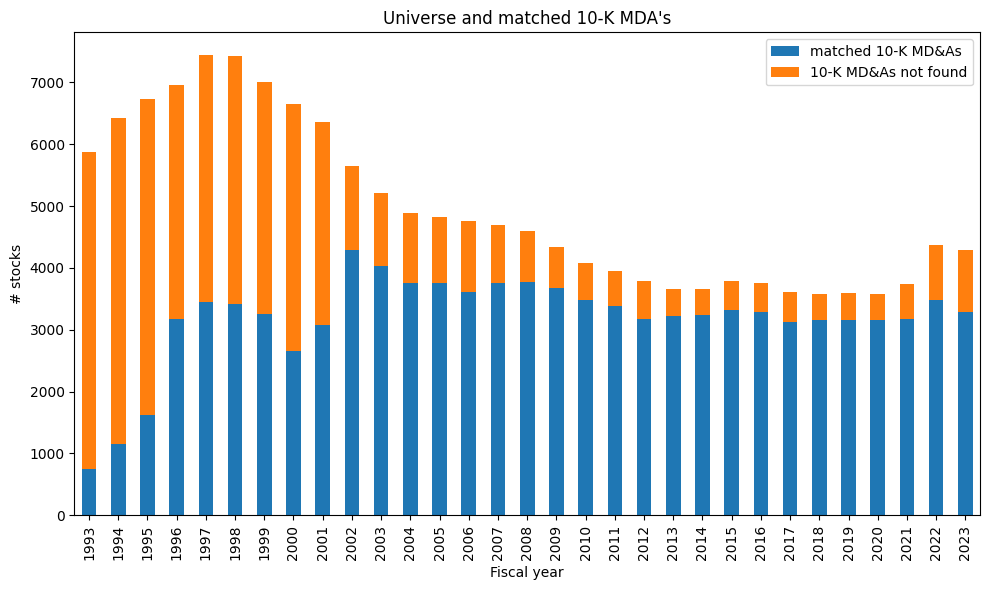

In [23]:
# Stacked Bar Plot of universe coverage by year
y1 = data[data['mdasent'].notna()].groupby('year')['permno'].count()
y0 = data[data['mdasent'].isna()].groupby('year')['permno']\
                                 .count()\
                                 .reindex(y1.index)
fig, ax = plt.subplots(1, 1, clear=True, figsize=(10, 6))
y1.plot(kind='bar', label='matched 10-K MD&As', color='C0', ax=ax, rot=90)
y0.plot(kind='bar', label='10-K MD&As not found', color='C1', ax=ax, rot=90, bottom=y1)
ax.set_ylabel('# stocks')
ax.set_xlabel('Fiscal year')
ax.set_title("Universe and matched 10-K MDA's")
ax.legend()
plt.tight_layout()

When are 10-K's filed?

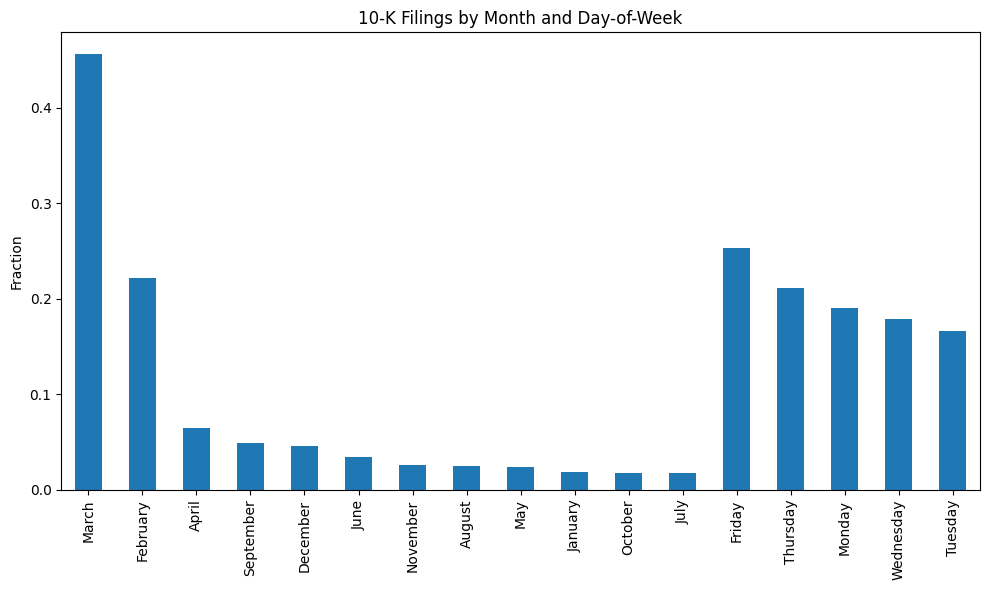

In [18]:
# Stacked Bar Plot of filings date, by month and day-of-week
y = DataFrame.from_records([{'date': int(d),
                             'day': bd.datetime(int(d)).strftime('%A'),
                             'month': bd.datetime(int(d)).strftime('%B')}
                            for d in data.loc[data['mdasent'].notna(), 'date']])
z = pd.concat([y['month'].value_counts()/len(y),
               y['day'].value_counts()/len(y)])
fig, ax = plt.subplots(1, 1, clear=True, figsize=(10, 6))
z.plot(kind='bar', color='C0', ax=ax, rot=90)
ax.set_ylabel('Fraction')
ax.set_title("10-K Filings by Month and Day-of-Week")
plt.tight_layout()

Median sentiment and change in sentiment vs total corporate profits (of all US companies), by year:

mdasent sentiment
mdachg sentiment change


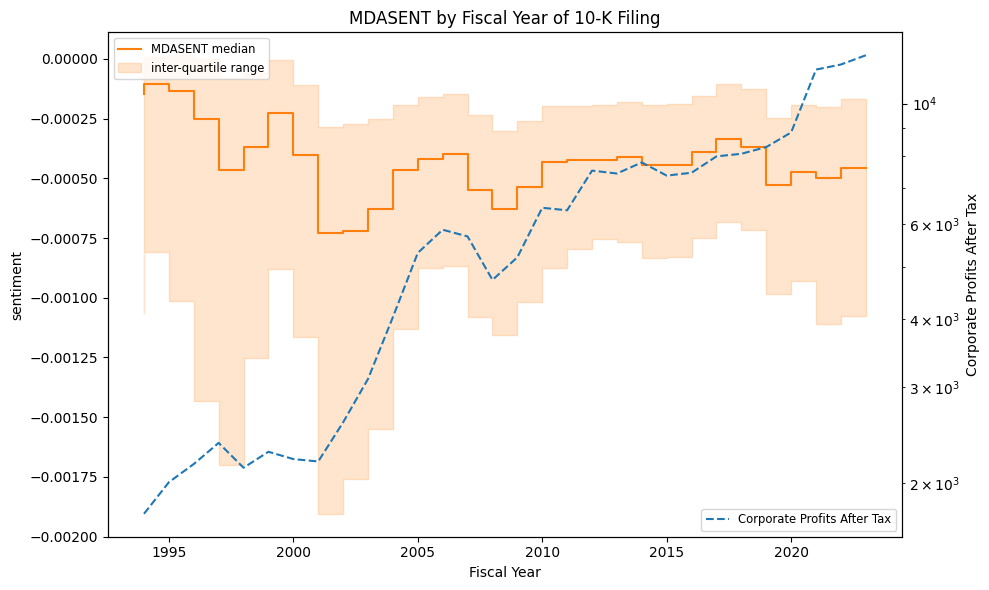

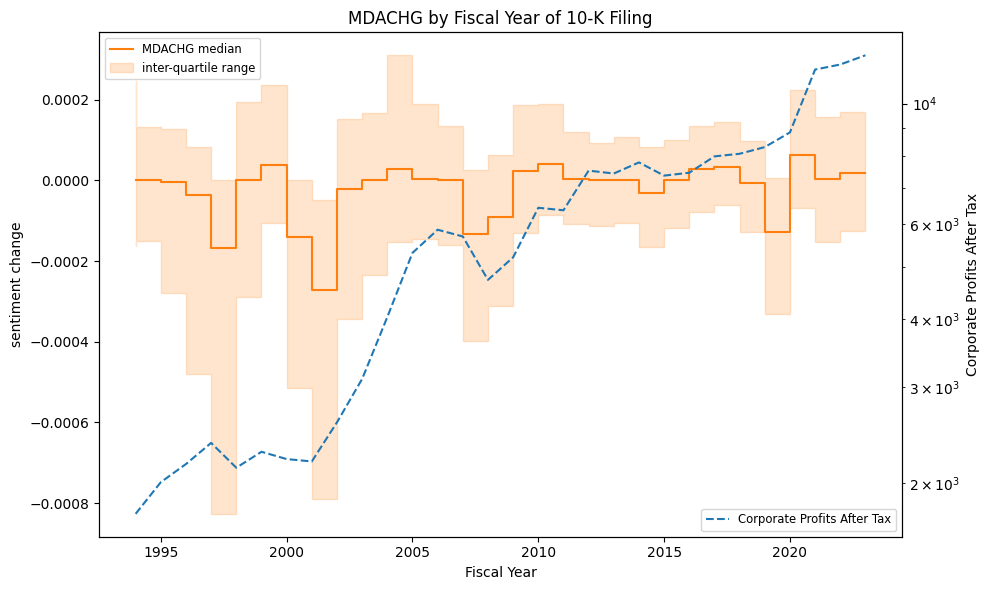

In [19]:
alf = Alfred(api_key=credentials['fred']['api_key'], verbose=VERBOSE)
series_id = 'CP'  # Corporate Profits
econ = alf(series_id).to_frame()
econ = econ.assign(year=econ.index // 10000).groupby('year').sum()
           
for sent, ylab in {'mdasent': 'sentiment', 'mdachg': 'sentiment change'}.items():
    print(sent, ylab)
    g = data[data['currlen'].gt(500)].dropna().groupby('year')
    iq1, iq2, iq3 = [g[sent].quantile(p) for p in [.25, .5, .75]]
    y = iq2.index.astype(int)
    fig, ax = plt.subplots(1, 1, clear=True, figsize=(10, 6))
    ax.step(y, iq2, ls='-', color='C1', where='pre')
    ax.fill_between(y, iq1, iq3, alpha=0.2, color='C1', step='pre')
    ax.set_title(f"{sent.upper()} by Fiscal Year of 10-K Filing")
    ax.set_xlabel("Fiscal Year")
    ax.set_ylabel(ylab)
    ax.legend([f"{sent.upper()} median", f"inter-quartile range"],
              fontsize='small', loc='upper left')

    bx = ax.twinx()
    econ[(econ.index >= min(y)) & (econ.index <= max(y))].plot(ls='--', ax=bx)
    bx.legend([alf.header(series_id)[:27]], fontsize='small', loc='lower right')
    bx.set_ylabel(alf.header(series_id)[:27])
    bx.set_yscale('log')
    plt.tight_layout()

### Management sentiment and stock returns


We analyze the relationship between sentiment in 10-K filings and subsequent stock returns by constructing cap-weighted decile-spread returns. These are calculated for two periods:
1. The same calendar year (January–December) to examine contemporaneous relationships between sentiment and stock performance.
2. The following year (April–March) to explore an investable strategy based on sentiment changes after the release of 10-K reports for the prior fiscal year.



  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:48<00:00,  1.92s/it]


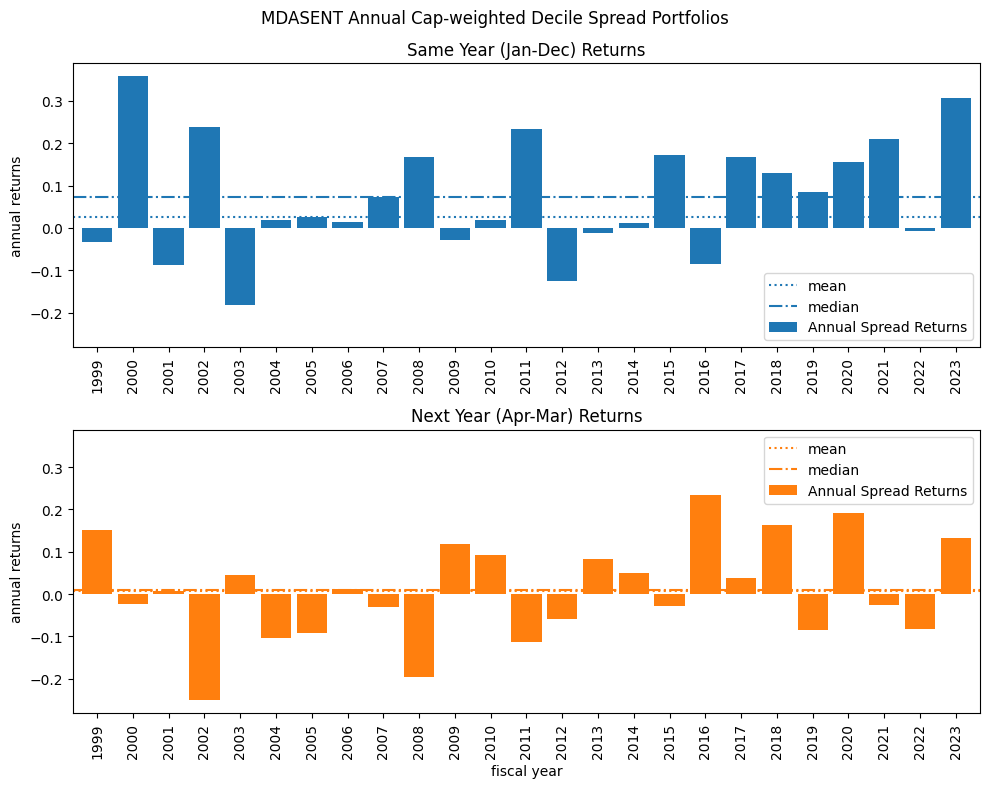

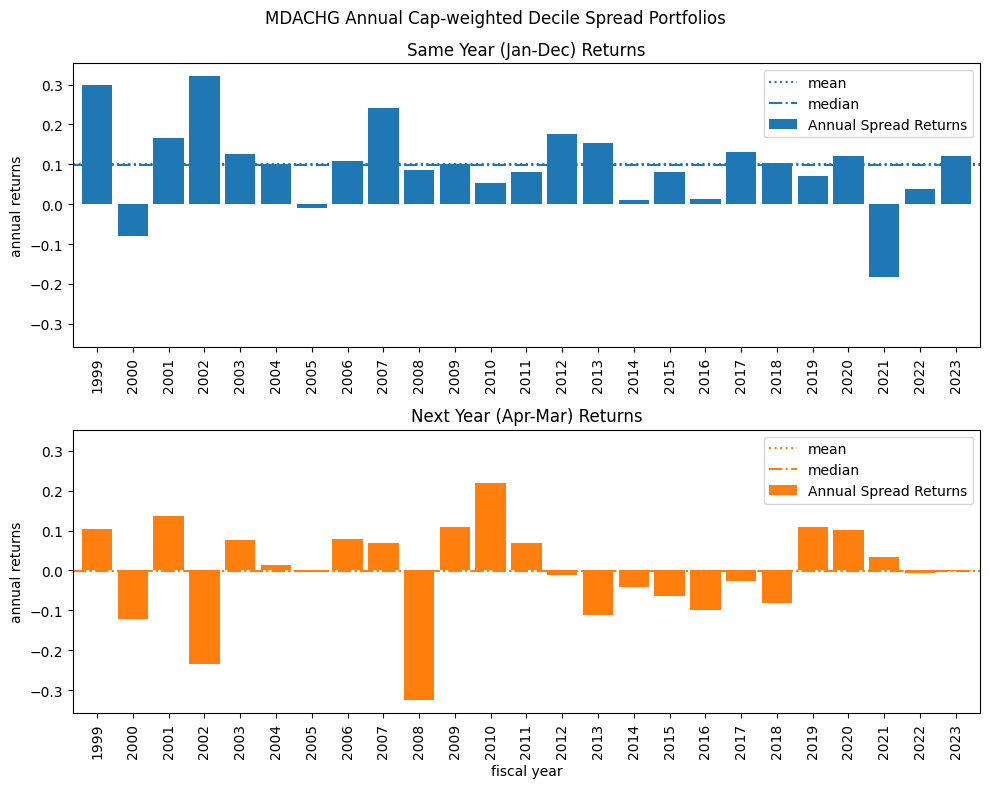

In [22]:
for ifig, key in enumerate(['mdasent', 'mdachg']):
    ret1 = {}   # to collect year-ahead spread returns
    ret0 = {}   # to collect current-year spread returns
    for year in tqdm(range(1999, max(data['year'])+1)):  # loop over years
        
        # compute current year average spread returns
        begyr = bd.begyr(year)
        endyr = bd.endyr(year)
        univ = data[data['year'] == year]\
                   .dropna(subset=[key])\
                   .set_index('permno')\
                   .join(crsp.get_cap(bd.offset(begyr, -1)), how='inner')\
                   .join(crsp.get_ret(begyr, endyr), how='left')
        if len(univ):
            sub = fractile_split(univ[key], [10, 90])
            pos = weighted_average(univ.loc[sub==1, ['cap', 'ret']], 'cap')['ret']
            neg = weighted_average(univ.loc[sub==3, ['cap', 'ret']], 'cap')['ret']
            ret0[endyr] = {'ret': pos-neg, 'npos': sum(sub==1), 'nneg': sum(sub==3)}

        # compute year ahead average spread returns
        beg = bd.begmo(endyr, 4)
        end = bd.endmo(endyr, 15)
        univ = data[data['year'] == year]\
                   .dropna(subset=[key])\
                   .set_index('permno')\
                   .join(crsp.get_cap(bd.offset(beg, -1)), how='inner')\
                   .join(crsp.get_ret(beg, end), how='left')
        if len(univ):
            sub = fractile_split(univ[key], [10, 90])
            pos = weighted_average(univ.loc[sub==1, ['cap', 'ret']], 'cap')['ret']
            neg = weighted_average(univ.loc[sub==3, ['cap', 'ret']], 'cap')['ret']
            ret1[end] = {'ret': pos-neg, 'npos': sum(sub==1), 'nneg': sum(sub==3)}

    # collect same-year and year-ahead average spread returns
    r0 = DataFrame.from_dict(ret0, orient='index').sort_index()
    r0.index = r0.index // 10000
    r1 = DataFrame.from_dict(ret1, orient='index').sort_index()
    r1.index = (r1.index // 10000) - 2

    # plot same-year average spread returns
    fig, ax = plt.subplots(nrows=2, clear=True, figsize=(10, 8), sharey=True)
    r0['ret'].plot(kind='bar', ax=ax[0], width=.85, color="C0")
    ax[0].axhline(r0['ret'].median(), linestyle=':', color='C0')
    ax[0].axhline(r0['ret'].mean(), linestyle='-.', color='C0')
    ax[0].set_title(f"Same Year (Jan-Dec) Returns")
    ax[0].set_ylabel('annual returns')
    ax[0].legend(['mean', 'median', 'Annual Spread Returns'])
    
    # plot year-ahead average spread returns
    r1['ret'].plot(kind='bar', ax=ax[1], width=.85, color="C1")
    ax[1].axhline(r1['ret'].median(), linestyle=':', color='C1')
    ax[1].axhline(r1['ret'].mean(), linestyle='-.', color='C1')
    ax[1].set_title(f"Next Year (Apr-Mar) Returns")
    ax[1].set_ylabel('annual returns')
    ax[1].legend(['mean', 'median', 'Annual Spread Returns'])
    ax[1].set_xlabel('fiscal year')
    
    plt.suptitle(f"{key.upper()} Annual Cap-weighted Decile Spread Portfolios")    
    plt.tight_layout()

**References:**

Tim Loughran and Bill McDonald, 2011, When is a Liability not a Liability? Textual Analysis, Dictionaries, and 10-Ks, Journal of Finance, 66:1, 35-65. 

Cohen, Malloy and Nguyen (2020), Lazy Prices, Journal of Finance, Volume 75, Issue3, June 2020, Pages 1371-1415
